In [1]:
import sys
import json
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
import wandb
from ignite.contrib.handlers import wandb_logger
from ignite.engine import (Engine, Events, create_supervised_evaluator,
                           create_supervised_trainer)
from ignite.handlers import ModelCheckpoint
from ignite.handlers.param_scheduler import LRScheduler
from ignite.metrics import Accuracy, Loss
from scipy.io.arff import loadarff
from sklearn.model_selection import train_test_split
from torch import nn
from torch.functional import F
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler

sys.path.append('../')
from src.datasets import FordDataset
from src.models import LSTMClassification
from src.utils import build_optimizer, str2torch

In [2]:
config = {
    "model":{
        "lstm": {
            "input_dim": 500,
            "hidden_dim": 100,
            "num_layers": 2    
        },
        "fc":{
            "fc_dim": 50,
            "dropout": 0
        }
    },
    "train":{
        "optimizer": "adam",
        "lr": 3e-4,
        "n_epoch": 20
    },
    "data":{
        "seq_length": 500,
        "step": 25
    },
    "random_state": 42
}

with open("../configs/lstm_config.json", 'w') as file:
    json.dump(config, file, indent=4)

In [3]:
train_path = "../data/FordA/FordA_TRAIN.arff"
test_path = "../data/FordA/FordA_TEST.arff"

train_dataset = FordDataset(train_path, config['data'])
test_dataset = FordDataset(test_path, config['data'])

idx = np.arange(len(train_dataset))
idx_train, idx_val = train_test_split(idx, train_size=0.8, stratify=train_dataset.labels, random_state=config['random_state'])

train_sampler = SubsetRandomSampler(idx_train)
val_sampler = SubsetRandomSampler(idx_val)

train_dataloader = DataLoader(train_dataset, batch_size=128, sampler=train_sampler)
val_dataloader = DataLoader(train_dataset, batch_size=128, sampler=val_sampler)
test_dataloader = DataLoader(test_dataset, batch_size=64)

In [4]:
# Initialize your model
wandb.init(entity='ts-robustness', project='ml-course', config=config)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config['train']['optimizer'] = str2torch(config['train']['optimizer'])
print('device:',device)

wandb: Currently logged in as: gamma_function (ts-robustness). Use `wandb login --relogin` to force relogin


device: cuda


In [5]:
model = LSTMClassification(config['model']).to(device)

In [6]:
# Initialize your optimizer and criterion
optimizer = build_optimizer(config, model)
criterion = nn.BCELoss()

def train_step(engine, batch):
    model.train()
    optimizer.zero_grad()
    x, y = batch[0].to(device), batch[1].to(device)
    y_pred = model(x)
    
    loss = criterion(y_pred, y.unsqueeze(1))
    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_step)

def validation_step(engine, batch):
    model.eval()
    with torch.no_grad():
        x, y = batch[0].to(device), batch[1].to(device)
        y_pred = model(x)
        return y_pred, y

train_evaluator = Engine(validation_step)
val_evaluator = Engine(validation_step)

# Attach metrics to the evaluators
metrics = {
    'accuracy': Accuracy(output_transform=lambda x: (x[0] > 0.5, x[1])),
    'loss': Loss(criterion, output_transform=lambda x: (x[0], x[1].unsqueeze(1)))
}

for name, metric in metrics.items():
    metric.attach(train_evaluator, name)

for name, metric in metrics.items():
    metric.attach(val_evaluator, name)


# checkpoint_handler = ModelCheckpoint(dirname='saved_models', filename_prefix='best',
#                                      n_saved=1, require_empty=False,
#                                      score_function=lambda engine: engine.state.metrics['accuracy'],
#                                      score_name="accuracy", global_step_transform=lambda *_: trainer.state.epoch)
# val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, checkpoint_handler, {"model": model})


### Logging
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(trainer):
    batch_loss = trainer.state.output
    print("Training Results - Avg loss: {:.4f}".format(batch_loss))
    wandb.log({"train_loss": batch_loss})
    
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_dataloader)
    metrics = train_evaluator.state.metrics
    print("Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.4f}"
          .format(trainer.state.epoch, metrics['accuracy'], metrics['loss']))
    wandb.log({"train_accuracy": metrics['accuracy'],
               "train_loss": metrics['loss']})

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_dataloader)
    metrics = val_evaluator.state.metrics
    print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.4f}"
          .format(trainer.state.epoch, metrics['accuracy'], metrics['loss']))
    wandb.log({"val_accuracy": metrics['accuracy'],
               "val_loss": metrics['loss']})


# Run the training loop
trainer.run(train_dataloader, max_epochs=config['train']['n_epoch'])
wandb.finish()

Training Results - Avg loss: 0.6966
Training Results - Avg loss: 0.6955
Training Results - Avg loss: 0.6971
Training Results - Avg loss: 0.6938
Training Results - Avg loss: 0.6915
Training Results - Avg loss: 0.6952
Training Results - Avg loss: 0.6914
Training Results - Avg loss: 0.6963
Training Results - Avg loss: 0.6946
Training Results - Avg loss: 0.6952
Training Results - Avg loss: 0.6943
Training Results - Avg loss: 0.6919
Training Results - Avg loss: 0.6901
Training Results - Avg loss: 0.6923
Training Results - Avg loss: 0.6924
Training Results - Avg loss: 0.6931
Training Results - Avg loss: 0.6934
Training Results - Avg loss: 0.6935
Training Results - Avg loss: 0.6921
Training Results - Avg loss: 0.6927
Training Results - Avg loss: 0.6924
Training Results - Avg loss: 0.6925
Training Results - Avg loss: 0.6952
Training Results - Epoch: 1  Avg accuracy: 0.53 Avg loss: 0.6919
Validation Results - Epoch: 1  Avg accuracy: 0.52 Avg loss: 0.6921
Training Results - Avg loss: 0.6921
Trai

train_accuracy,▁▂▃▄▄▅▆▆▇▇▇█████████
train_loss,████████▇▇▆▆▅▆▄▄▄▄▃▂▃▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▃▅▅▆▇▇█▇██████▇███
val_loss,▆▆▆▅▃▂▂▁▁▂▂▃▂▄▅▅▆▇██
train_accuracy,0.99757
train_loss,0.01759
val_accuracy,0.77531
val_loss,0.76301


In [19]:
PATH = '../model/lstm_model.pt'
torch.save(model.state_dict(), PATH)

In [7]:
def req_grad(model: nn.Module, state: bool = True) -> None:
    """Set requires_grad of all model parameters to the desired value.

    :param model: the model
    :param state: desired value for requires_grad
    """
    for param in model.parameters():
        param.requires_grad_(state)

In [56]:
def BMI_attack(num_iterations):
    epsilon = 0.01
    req_grad(model, state=True)
    model.train()
    loss_function = torch.nn.BCELoss()
    
    correct = 0
    total = 0
    for input, target in test_dataloader:
        input = input.to(device)
        target = target.to(device)
        
        adversarial_input = input.clone().requires_grad_(True)  
        
        
        for _ in range(num_iterations):
            adversarial_input.requires_grad = True
            #print(adversarial_input.requires_grad)
            predictions = model(adversarial_input)
            loss = loss_function(predictions.flatten(), target)
            
            grad_ = torch.autograd.grad(loss, adversarial_input, retain_graph=True)[0]
            adversarial_input = adversarial_input.data + epsilon * torch.sign(grad_)
    
        adversarial_predictions = model(adversarial_input)
        correct += (adversarial_predictions.to('cpu').round().reshape(1,-1) == target.to('cpu')).sum().item()
        total += len(target)
    return correct/total, input, adversarial_input

In [57]:
from tqdm import tqdm
number_iterations = np.arange(0,30,1)
list_accuracy = []

for i in tqdm(number_iterations):
    acc, inp, adv_inp = BMI_attack(i)
    list_accuracy.append(acc)

100%|██████████| 30/30 [00:12<00:00,  2.41it/s]


In [58]:
print(list_accuracy[0])
print(1-list_accuracy[-1])

0.7712121212121212
0.7598484848484849


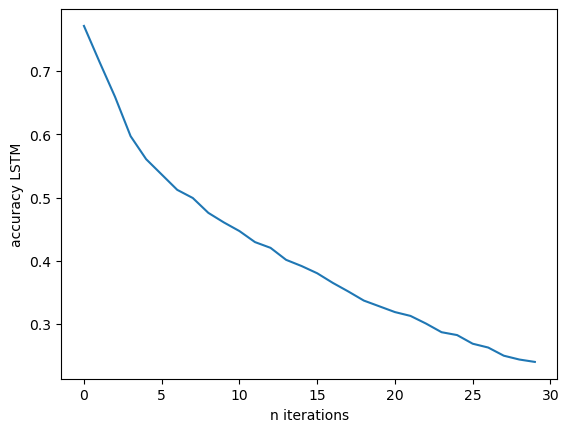

In [59]:
plt.plot(number_iterations, list_accuracy)
plt.xlabel('n iterations')
plt.ylabel('accuracy LSTM')
plt.show()

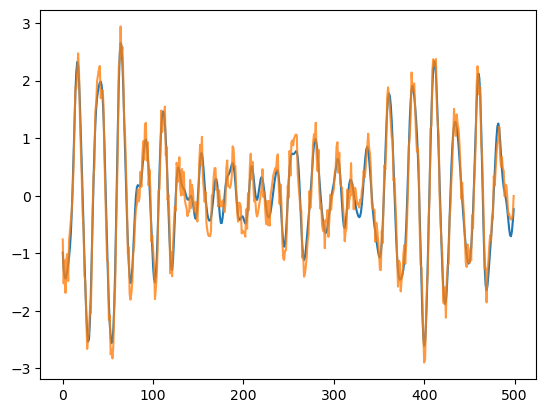

In [60]:
plt.plot(inp[0].to('cpu'))
plt.plot(adv_inp[0].to('cpu').detach().numpy(), alpha=0.8)